### <p style="text-align: center;">K-Means Cluster Analysis of Venues in the Bronx and Staten Island</p>
#### <p style="text-align: center;">A Data Science Project</p>     
##### <p style="text-align: center;">by David Anim-Addo</p>

In [470]:
#The purpose of this project is to cluster, visualize, and analyze neighborhoods in the Bronx 
#and Staten Island to aid in public health assessments.  

import pandas as pd #load library for data analysis
import numpy as np #load library for vector data management
import requests #load http library to send requests with python
import matplotlib.pyplot as plt #load a 2D plotting library
import matplotlib.cm as cm #load for built in color maps
import matplotlib.colors as colors #load for color plotting
import time #load time library to delay geocoder requests

#set backend of matplotlib to inline backend
%matplotlib inline 

!conda install -c conda beautifulsoup4 --yes #install the beautifulsoup package for webscraping
from bs4 import BeautifulSoup as bs

!conda install -c conda lxml --yes #install to handle html files

!conda install -c conda-forge geopy --yes #install geocoder for location data
from geopy.geocoders import Nominatim as nm

!conda install -c conda-forge geopandas --yes #install to allow spatial operations on geometric types

!conda install -c conda-forge folium=0.5.0 --yes #install for map rendering
import folium 

from pandas.io.json import json_normalize #load to convert json file to pandas dataframe

from sklearn.cluster import KMeans #load for clustering analysis
from sklearn.datasets.samples_generator import make_blobs #generate gaussian blobs for clustering

#Install the Yellowbrick library and import the kmeans elbow visualizer
!conda install -c districtdatalabs yellowbrick --yes
from yellowbrick.cluster import KElbowVisualizer

print("Packages installed.")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11

### Scrape the data, clean the data, and explore it
Use beautifulsoup to scrape the data off of wikipedia, then insert it into a dataframe and clean it.  

In [386]:
#Assign the website to a variable and request it
url_staten = 'https://en.wikipedia.org/wiki/List_of_Staten_Island_neighborhoods'
rq_staten = requests.get(url_staten)

url_bronx = 'https://en.wikipedia.org/wiki/List_of_Bronx_neighborhoods'
rq_bronx = requests.get(url_bronx)

In [387]:
#Use beautifulsoup as bs to webscrape the names
soup = bs(rq_staten.content,'html')
names_staten = soup.find_all(string=True)[62:195:2]
soup = bs(rq_bronx.content,'html')
names_bronx = soup.find_all(string=True)[183:397]

#Clean names_bronx, leaving only bronx neighborhood names
for i in names_bronx:
    if i == '\n':
        names_bronx.remove(i)
        
for i in names_bronx:
    if i == ' (':
        names_bronx.remove(i)
        
for i in names_bronx:
    if i == ')':
        names_bronx.remove(i)
        
for i in names_bronx:
    if i == '[':
        names_bronx.remove(i)

for i in names_bronx:
    if i == ']':
        names_bronx.remove(i)
        
for i in names_bronx:
    if i == ' ':
        names_bronx.remove(i)
        
for i in names_bronx:
    if i == 'edit':
        names_bronx.remove(i)

#Remove all strings that are not needed
names_bronx.remove(' previously the grounds of the ') 
names_bronx.remove(' (part of Manhattan, but often associated with the Bronx due to its mainland location)')
names_bronx.remove(' (South Riverdale)')
names_bronx.remove(' (North of ')
names_bronx.remove(' (on the border of East and West)')
names_bronx.remove(' owned a home off Seminole.')  
names_bronx.remove('(also spelled Throgs Neck)')                  
names_bronx.remove('Main article: ')
names_bronx.remove('List of smaller islands in New York City')
names_bronx.remove(' – The historical name for a group of uninhabited islands.\n')
names_bronx.remove(' – The only inhabited island.')
names_bronx.remove('Southeast Bronx')
names_bronx.remove('Southwest Bronx')
names_bronx.remove('Northeast Bronx')
names_bronx.remove('Islands')
names_bronx.remove('The Pelham Islands')
names_bronx.remove('Jerome Park Racetrack')

#Replace strings with the appropriate names
names_bronx[64]='Indian Village'
names_bronx[75]='Unionport'



In [388]:
#Define the columns of a dataframe
hood_columns = ['Borough', 'Neighborhood'] 

#Create an instance of the dataframe
hood_data = pd.DataFrame(columns=hood_columns)
hood_data

,Borough,Neighborhood


In [389]:
#Append the data table with Staten Island neighborhood names
for name in names_staten:
    borough = 'Staten Island'
    hood_data = hood_data.append({'Borough': borough,'Neighborhood': name}, ignore_index=True)

hood_data.shape

(67, 2)

In [390]:
#Append the data table with Bronx neighborhood names
for name in names_bronx:
    borough = 'Bronx'
    hood_data = hood_data.append({'Borough': borough,'Neighborhood': name}, ignore_index=True)

hood_data.shape

(156, 2)

In [391]:
hood_data.head()

,Borough,Neighborhood
0,Staten Island,Annadale
1,Staten Island,Arden Heights
2,Staten Island,Arlington
3,Staten Island,Arrochar
4,Staten Island,Bay Terrace


In [404]:
from geopy.exc import GeocoderTimedOut

def do_geocode(address):
    try:
        return geopy.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)

In [406]:
#Use the geocoder to load location data into a dataframe
locator = nm(user_agent='ny_geocoder')

hood_lat=[]
hood_long=[]
BACKOFF_TIME=1

for hood in hood_data['Neighborhood']:
    location = locator.geocode('{}, New York City, New York'.format(hood))
    if location == None:
        lat = pd.DataFrame({'Latitude': ['Nan']})  
        long = pd.DataFrame({'Longitude': ['Nan']})
        hood_lat.append(lat)
        hood_long.append(long)
    else:
        lat = pd.DataFrame({'Latitude': [location.latitude]})  
        long = pd.DataFrame({'Longitude': [location.longitude]})
        hood_lat.append(lat)
        hood_long.append(long)
        time.sleep(BACKOFF_TIME)

#Concatenate the location data along the rows axis
hood_lat = pd.concat(hood_lat, axis=0)
hood_long = pd.concat(hood_long, axis=0)

In [407]:
#Join the dataframes along the column axis
hood_long = hood_long.reset_index(drop=True)
hood_lat = hood_lat.reset_index(drop=True)
hood_data_loc = pd.concat([hood_data, hood_lat, hood_long], axis=1)
hood_data_loc.head()

,Borough,Neighborhood,Latitude,Longitude
0,Staten Island,Annadale,40.5445,-74.1765
1,Staten Island,Arden Heights,Nan,Nan
2,Staten Island,Arlington,40.6323,-74.1651
3,Staten Island,Arrochar,40.5984,-74.0726
4,Staten Island,Bay Terrace,40.5553,-74.1342


In [408]:
#Clean the dataframe by removing any locations with 'Nan'
hood_data_loc = hood_data_loc[hood_data_loc.Latitude != 'Nan'].reset_index(drop=True)
hood_data_loc = hood_data_loc[hood_data_loc.Longitude != 'Nan'].reset_index(drop=True)
hood_data_loc.shape


(137, 4)

In [409]:
hood_data_loc.head()

,Borough,Neighborhood,Latitude,Longitude
0,Staten Island,Annadale,40.5445,-74.1765
1,Staten Island,Arlington,40.6323,-74.1651
2,Staten Island,Arrochar,40.5984,-74.0726
3,Staten Island,Bay Terrace,40.5553,-74.1342
4,Staten Island,Bloomfield,40.6126,-74.1782


In [410]:
#Compare the number of neighborhoods in Staten Island and the Bronx
boro_count = pd.DataFrame(hood_data_loc.Borough.value_counts().reset_index())
boro_count.columns = ['Borough', 'Count']
print(boro_count)

         Borough  Count
0          Bronx     77
1  Staten Island     60


In [411]:
#Find the coordinates of New York City
nyc_address = 'New York City, New York'

nyc_geo = nm(user_agent="nyc_explorer")
nyc_loc = nyc_geo.geocode(nyc_address)
nyc_lat = nyc_loc.latitude
nyc_long = nyc_loc.longitude
print('The coordinates of New York City, New York are {}, {}.'.format(nyc_lat, nyc_long))

The coordinates of New York City, New York are 40.7127281, -74.0060152.


In [412]:
# Create map of New York City, New York using latitude and longitude values
map_nyc = folium.Map(location=[nyc_lat, nyc_long], zoom_start=10)

# Place neighborhood markers on the map
for nyc_lat, nyc_lng, label in zip(hood_data_loc['Latitude'], hood_data_loc['Longitude'], hood_data_loc['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [nyc_lat, nyc_lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)  
    
map_nyc

In [413]:
#Create a list of neighborhoods with incorrect locations
error_loc = ['Manor Heights', 'Mount Hope', 'Lighthouse Hill', 'Washingtonville', 'Shore Acres', 'Hudson Hill', 'Park Versailles', 'Chelsea', 'Sunnyside', 'Woodstock', 'The Hub']
error_loc

['Manor Heights',
 'Mount Hope',
 'Lighthouse Hill',
 'Washingtonville',
 'Shore Acres',
 'Hudson Hill',
 'Park Versailles',
 'Chelsea',
 'Sunnyside',
 'Woodstock',
 'The Hub']

In [414]:
#Remove rows with errors in latitude, longitude
for error in error_loc:
    hood_data_loc = hood_data_loc[hood_data_loc.Neighborhood != error].reset_index(drop=True)
print(hood_data_loc.shape)

(126, 4)


#### Gather the venue data for each neighborhood in Staten Island and the Bronx


In [415]:
#Load Foursquare credentials to search nearby venues in each neighborhood
CLIENT_ID = '***' # your Foursquare ID
CLIENT_SECRET = '***' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ***CLIENT_SECRET:***

In [416]:
#Create a function to gather venue data for each neighborhood in Staten Island, Bronx into a dataframe
def getNearbyVenues(names, latitudes, longitudes, radius=500):

    venues_neigh = []
    venues_neigh_lat = []
    venues_neigh_lng = []
    venues_ven = []
    venues_lat = []
    venues_lng = []
    venues_cat = []
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # Call using the Foursquare api
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            VERSION,
            radius, 
            LIMIT)
         
        # Create the get request for the url
        results = requests.get(url).json()
        
        venues = results['response']['venues']

        # Flatten the json file
        close_venues = json_normalize(venues) 

        # Filter the coloumns
        filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
        close_venues = close_venues.loc[:, filtered_columns]

        # This function extracts the category of the venues
        def get_category_type(row):
            try:
                categories_list = row['categories']
            except:
                categories_list = row['venue.categories']

            if len(categories_list) == 0:
                return None
            else:
                return categories_list[0]['name']

        # Filter the categories of the rows
        close_venues['categories'] = close_venues.apply(get_category_type, axis=1)

        # Clean the columns for appending
        close_venues.columns = [col.split(".")[-1] for col in close_venues.columns]
        
        close_venues_pd = pd.DataFrame(close_venues)
        
        #This loop fills dataframes with venue name, location, and category
        for v in close_venues_pd:
            ven = pd.DataFrame({'Venue': close_venues_pd['name']})
            ven_lat = pd.DataFrame({'Venue Latitude': close_venues_pd['lat']})
            ven_lng = pd.DataFrame({'Venue Longitude': close_venues_pd['lng']})
            ven_cat = pd.DataFrame({'Venue Category': close_venues_pd['categories']})
        
        count_venues = len(ven) #Find count of venues, then fill name, lat, lng *count_venues times
        
        neigh = pd.DataFrame({'Neighborhood': [name]*count_venues})
        neigh_lat = pd.DataFrame({'Neighborhood Latitude': [lat]*count_venues})
        neigh_lng = pd.DataFrame({'Neighborhood Longitude': [lng]*count_venues})

        # Return only the needed information for each nearby venue
        venues_neigh.append(neigh)
        venues_neigh_lat.append(neigh_lat)
        venues_neigh_lng.append(neigh_lng)
        venues_ven.append(ven)
        venues_lat.append(ven_lat)
        venues_lng.append(ven_lng)
        venues_cat.append(ven_cat)
    
    #Concatenate each dataframe, reset the indices, and join the tables along the column axis
    venues_neigh = pd.concat(venues_neigh, axis=0)
    venues_neigh_lat = pd.concat(venues_neigh_lat, axis=0)
    venues_neigh_lng = pd.concat(venues_neigh_lng, axis=0)
    venues_ven = pd.concat(venues_ven, axis=0)
    venues_lat = pd.concat(venues_lat, axis=0)
    venues_lng = pd.concat(venues_lng, axis=0)
    venues_cat = pd.concat(venues_cat, axis=0)

    venues_neigh = venues_neigh.reset_index(drop=True)
    venues_neigh_lat = venues_neigh_lat.reset_index(drop=True)
    venues_neigh_lng = venues_neigh_lng.reset_index(drop=True)
    venues_ven = venues_ven.reset_index(drop=True)
    venues_lat = venues_lat.reset_index(drop=True)
    venues_lng = venues_lng.reset_index(drop=True)
    venues_cat = venues_cat.reset_index(drop=True)
    
    venues_nearby = pd.concat((venues_neigh, venues_neigh_lat, venues_neigh_lng, venues_ven, 
                               venues_lat, venues_lng, venues_cat), axis=1)
    return(venues_nearby)
           

In [417]:
#Run the getNearbyVenues function for each neighborhood and create a new dataframe
hood_venues = getNearbyVenues(names=hood_data_loc['Neighborhood'],
                                   latitudes=hood_data_loc['Latitude'],
                                   longitudes=hood_data_loc['Longitude']
                                   )

In [418]:
hood_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Annadale,40.54455,-74.176532,La Fontana Sorellena,40.544480,-74.176508,Italian Restaurant
1,Annadale,40.54455,-74.176532,Drumgoole/Arden Overpass,40.546162,-74.180536,Bridge
2,Annadale,40.54455,-74.176532,MTA Bus - Annadale Rd & Arden Av (S55),40.544326,-74.176667,Bus Stop
3,Annadale,40.54455,-74.176532,Joes Basement,40.524786,-74.290479,Bar
4,Annadale,40.54455,-74.176532,MTA SIR - Annadale,40.540482,-74.178185,Train Station


In [419]:
hood_venues.shape

(12240, 7)

In [421]:
#Group the table by neighborhood and find the count of venues for each
hood_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,100,100,100,100,100,89
Annadale,100,100,100,100,100,79
Arlington,100,100,100,100,100,90
Arrochar,100,100,100,100,100,89
Arthur Avenue,100,100,100,100,100,93
...,...,...,...,...,...,...
Williamsbridge,100,100,100,100,100,97
Willowbrook,100,100,100,100,100,89
Woodlawn,100,100,100,100,100,97


In [422]:
#Find the number of unique categories within the Staten Island and Bronx neighborhood data
print('There are {} unique categories.'.format(len(hood_venues['Venue Category'].unique())))

There are 473 unique categories.


In [423]:
# Encode categorical features into numerical with one hot encoding
hood_onehot = pd.get_dummies(hood_venues['Venue Category'], prefix="", prefix_sep="")

# Add the neighborhood column back onto dataframe
hood_onehot['Neighborhood'] = hood_venues['Neighborhood'] 

# Shift the neighborhood column to the first column
fixed_columns = [hood_onehot.columns[-1]] + list(hood_onehot.columns[:-1])
hood_onehot = hood_onehot[fixed_columns]

hood_onehot.head()

,Neighborhood,ATM,Accessories Store,Acupuncturist,Afghan Restaurant,African Restaurant,Airport,Airport Gate,Airport Service,Airport Tram,...,Wedding Hall,Weight Loss Center,Well,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio
0,Annadale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Annadale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Annadale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Annadale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Annadale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [424]:
hood_onehot.shape

(12240, 473)

In [425]:
hood_grouped = hood_onehot.groupby('Neighborhood').mean().reset_index()
hood_grouped.shape

(125, 473)

In [426]:
#This function sorts the venues in the dataframe returns them in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [427]:
#Create a new dataframe to display the top 5 venues in the Staten Island, Bronx neighborhoods 
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

#Create columns by the number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#Create a new dataframe for sorting
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighborhood'] = hood_grouped['Neighborhood']

for ind in np.arange(hood_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hood_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Salon / Barbershop,Deli / Bodega,Bank,Pizza Place,Pharmacy
1,Annadale,Salon / Barbershop,Pizza Place,Nail Salon,American Restaurant,Bar
2,Arlington,Automotive Shop,Bus Stop,Church,Building,Deli / Bodega
3,Arrochar,High School,Pizza Place,Office,Bus Stop,Doctor's Office
4,Arthur Avenue,Italian Restaurant,Deli / Bodega,Mexican Restaurant,Salon / Barbershop,Bus Line
5,Bay Terrace,Doctor's Office,Salon / Barbershop,Building,Italian Restaurant,Cemetery
6,Baychester,Doctor's Office,Bus Station,Bus Line,Office,Dentist's Office
7,Bedford Park,Residential Building (Apartment / Condo),Deli / Bodega,Building,Bus Line,Church
8,Belmont,Italian Restaurant,Bakery,Deli / Bodega,Salon / Barbershop,Doctor's Office
9,Bloomfield,Office,Doctor's Office,Business Center,Building,Hotel


## Clustering the Neighborhoods
Use K-Means clustering to form the neighborhoods into as many clusters as determined by the Elbow Method.  The clusters will then be examined for any defining characteristics.  

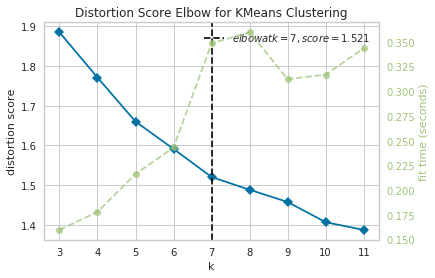

In [428]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,12))

X = hood_grouped.drop('Neighborhood', 1)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [429]:
#Enter the number of clusters
kclusters = 7

hood_grouped_clustering = hood_grouped.drop('Neighborhood', 1)

#Execute clustering with Kmeans
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hood_grouped_clustering)

#Review the cluster labels for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 6, 0, 1, 3, 3, 4, 1, 3], dtype=int32)

In [430]:
#Add clustering labels to the dataframe for analysis
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

hood_merged = hood_data_loc

#Merge the dataframes to add latitude/longitude for each neighbourhood
hood_merged = hood_merged.join(neighbourhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

hood_merged.head() 

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Staten Island,Annadale,40.5445,-74.1765,1,Salon / Barbershop,Pizza Place,Nail Salon,American Restaurant,Bar
1,Staten Island,Arlington,40.6323,-74.1651,6,Automotive Shop,Bus Stop,Church,Building,Deli / Bodega
2,Staten Island,Arrochar,40.5984,-74.0726,0,High School,Pizza Place,Office,Bus Stop,Doctor's Office
3,Staten Island,Bay Terrace,40.5553,-74.1342,3,Doctor's Office,Salon / Barbershop,Building,Italian Restaurant,Cemetery
4,Staten Island,Bloomfield,40.6126,-74.1782,3,Office,Doctor's Office,Business Center,Building,Hotel


In [431]:
hood_data_loc.shape

(126, 4)

In [432]:
#Create a cluster map of Staten Island, Bronx neighborhood venues
map_clusters = folium.Map(location=[nyc_lat, nyc_long], zoom_start=11)

#Assigne the color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Add markers onto the map
markers_colors = []
for lat, lon, poi, cluster in zip(hood_merged['Latitude'], hood_merged['Longitude'], hood_merged['Neighborhood'], hood_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Review of Clusters
Each of the 7 clusters are examined to assess the defining characteristics of the venue categories,
based on which an appropriate title will be given to the cluster.

## Cluster 0: Professional Venues

In [433]:
#Cluster(0)
clust0 = hood_merged.loc[hood_merged['Cluster Labels'] == 0, hood_merged.columns[[1] + list(range(5, hood_merged.shape[1]))]]
clust0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Arrochar,High School,Pizza Place,Office,Bus Stop,Doctor's Office
6,Castleton Corners,Building,Salon / Barbershop,Bank,Bar,Pizza Place
9,Concord,Doctor's Office,Building,Bus Station,Deli / Bodega,Bakery
10,Dongan Hills,Doctor's Office,Pizza Place,Bagel Shop,Food,Nail Salon
11,Egbertville,Office,Salon / Barbershop,Trail,Doctor's Office,Italian Restaurant
15,Fort Wadsworth,Government Building,Military Base,Bus Stop,Police Station,Historic Site
16,Graniteville,Gas Station,Nail Salon,Men's Store,Bus Stop,Dentist's Office
20,Greenridge,Pizza Place,Asian Restaurant,Parking,Laundry Service,Gym / Fitness Center
24,Huguenot,Salon / Barbershop,Building,Deli / Bodega,Bus Stop,Italian Restaurant
25,Livingston,Cemetery,Doctor's Office,Campground,Other Great Outdoors,Lake


In [467]:
#Create a table for count of common venues
df0 = clust0['1st Most Common Venue'].value_counts()
df0 = pd.DataFrame(df0)

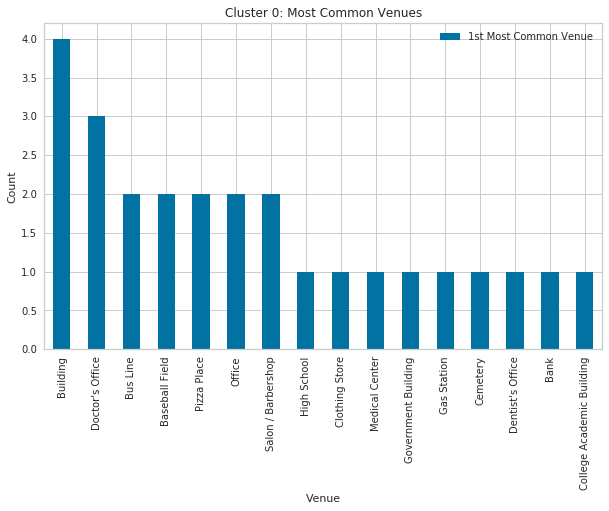

In [469]:
#Plot the Most Common Venues 
df0.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venue') #X-label
plt.ylabel('Count') #Y-label
plt.title('Cluster 0: Most Common Venues') #Plot Title

plt.show()

## Cluster 1 = Shop & Service Venues

In [435]:
#Cluster(1)
clust1 = hood_merged.loc[hood_merged['Cluster Labels'] == 1, hood_merged.columns[[1] + list(range(5, hood_merged.shape[1]))]]
clust1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Annadale,Salon / Barbershop,Pizza Place,Nail Salon,American Restaurant,Bar
19,Great Kills,Salon / Barbershop,Italian Restaurant,Bus Stop,Laundry Service,Lounge
34,Pleasant Plains,Salon / Barbershop,Pizza Place,Bakery,Church,Bank
37,Prince's Bay,Salon / Barbershop,Doctor's Office,Building,Dentist's Office,Ice Cream Shop
39,Richmond Valley,Salon / Barbershop,Nail Salon,Bakery,Automotive Shop,Building
45,Stapleton,Salon / Barbershop,Pizza Place,Food,Church,Deli / Bodega
51,Westerleigh,Salon / Barbershop,Doctor's Office,Bank,Building,Deli / Bodega
56,Belmont,Italian Restaurant,Bakery,Deli / Bodega,Salon / Barbershop,Doctor's Office
57,Arthur Avenue,Italian Restaurant,Deli / Bodega,Mexican Restaurant,Salon / Barbershop,Bus Line
60,Fordham Manor,Salon / Barbershop,Residential Building (Apartment / Condo),Deli / Bodega,Dentist's Office,Nail Salon


In [465]:
#Create a table for count of common venues
df1 = clust1['1st Most Common Venue'].value_counts()
df1 = pd.DataFrame(df1)

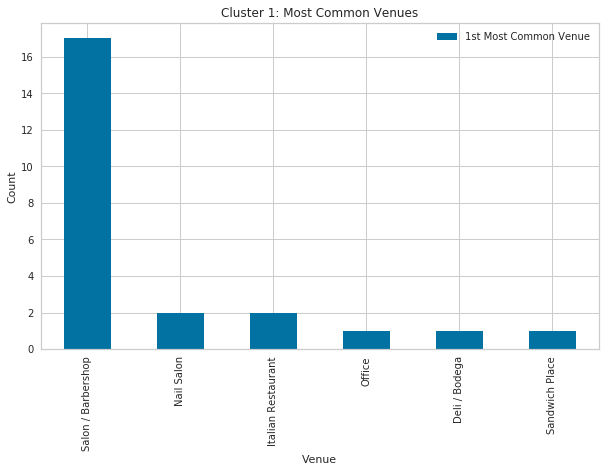

In [466]:
#Plot the Most Common Venues 
df1.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venue') #X-label
plt.ylabel('Count') #Y-label
plt.title('Cluster 1: Most Common Venues') #Plot Title

plt.show()

## Cluster 2: Travel & Transport Venues

In [437]:
#3rd Cluster(2)
clust2 = hood_merged.loc[hood_merged['Cluster Labels'] == 2, hood_merged.columns[[1] + list(range(5, hood_merged.shape[1]))]]
clust2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
93,City Island,Harbor / Marina,Bus Station,Italian Restaurant,Seafood Restaurant,Office
109,Pelham Bay,Boat or Ferry,Other Great Outdoors,Bus Station,Park,Harbor / Marina
116,Chimney Sweeps Islands,Boat or Ferry,Other Great Outdoors,Bus Station,Harbor / Marina,Park
117,City Island,Harbor / Marina,Bus Station,Italian Restaurant,Seafood Restaurant,Office
118,Hart Island,Harbor / Marina,Bus Station,Boat or Ferry,Office,Deli / Bodega
119,High Island,Boat or Ferry,Bus Station,Harbor / Marina,Seafood Restaurant,Other Great Outdoors
120,Hunter Island,Other Great Outdoors,Gas Station,Park,Harbor / Marina,Residential Building (Apartment / Condo)
121,Rat Island,Boat or Ferry,Bus Station,Harbor / Marina,Gas Station,Park
122,Twin Island,Harbor / Marina,Other Great Outdoors,Event Space,Park,Gas Station


In [463]:
#Create a table for count of common venues
df2 = clust2['1st Most Common Venue'].value_counts()
df2 = pd.DataFrame(df2)

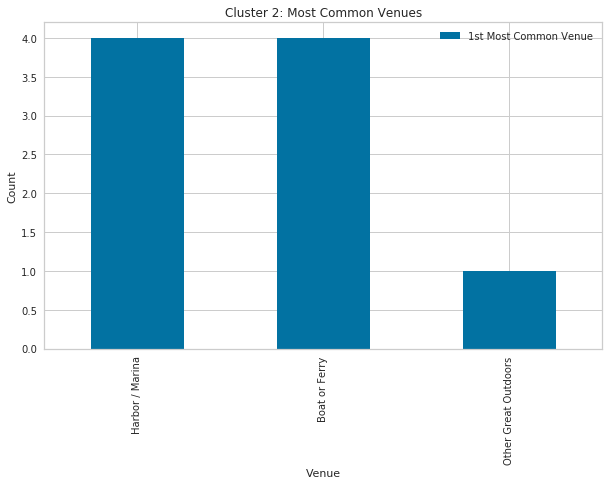

In [464]:
#Plot the Most Common Venues 
df2.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venue') #X-label
plt.ylabel('Count') #Y-label
plt.title('Cluster 2: Most Common Venues') #Plot Title

plt.show()

## Cluster 3: Professional/Medical Venues

In [439]:
#4th Cluster(3)
clust3 = hood_merged.loc[hood_merged['Cluster Labels'] == 3, hood_merged.columns[[1] + list(range(5, hood_merged.shape[1]))]]
clust3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Bay Terrace,Doctor's Office,Salon / Barbershop,Building,Italian Restaurant,Cemetery
4,Bloomfield,Office,Doctor's Office,Business Center,Building,Hotel
5,Bulls Head,Doctor's Office,Bus Stop,Building,Church,Chinese Restaurant
13,Eltingville,Doctor's Office,Nail Salon,Automotive Shop,Pizza Place,Office
14,Emerson Hill,Doctor's Office,Building,Gas Station,Other Great Outdoors,Bus Stop
17,Grant City,Doctor's Office,Salon / Barbershop,Automotive Shop,Church,Building
18,Grasmere,Doctor's Office,Building,Office,Medical Center,Bus Line
23,Heartland Village,Doctor's Office,Bus Line,Professional & Other Places,Student Center,School
29,New Dorp,Doctor's Office,Office,Bakery,Mexican Restaurant,Italian Restaurant
52,West New Brighton,Doctor's Office,Salon / Barbershop,Church,Moving Target,Building


In [460]:
#Create a table for count of common venues
df3 = clust3['1st Most Common Venue'].value_counts()
df3 = pd.DataFrame(df3)

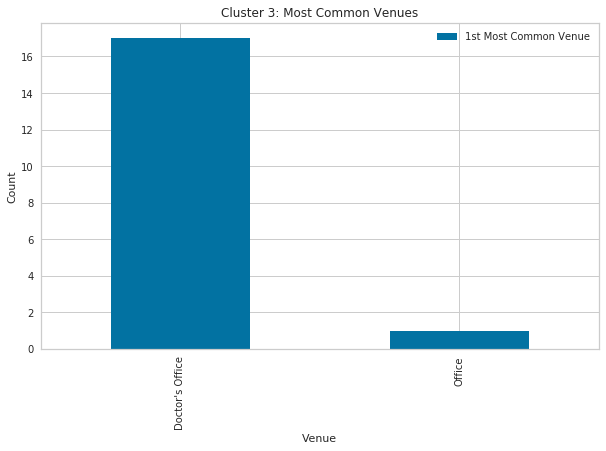

In [461]:
#Plot the Most Common Venues 
df3.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venue') #X-label
plt.ylabel('Count') #Y-label
plt.title('Cluster 3: Most Common Venues') #Plot Title

plt.show()

## Cluster 4: Residential Venues

In [441]:
#5th Cluster(4)
clust4 = hood_merged.loc[hood_merged['Cluster Labels'] == 4, hood_merged.columns[[1] + list(range(5, hood_merged.shape[1]))]]
clust4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
21,Grymes Hill,General College & University,Residential Building (Apartment / Condo),College Administrative Building,College Library,Scenic Lookout
55,Bedford Park,Residential Building (Apartment / Condo),Deli / Bodega,Building,Bus Line,Church
59,Fordham Heights,Residential Building (Apartment / Condo),Bus Line,Fried Chicken Joint,Bar,School
61,Jerome Park,College Classroom,Bus Line,High School,Residential Building (Apartment / Condo),Coworking Space
63,Kingsbridge Heights,Residential Building (Apartment / Condo),Deli / Bodega,Pizza Place,Bus Line,Building
66,Riverdale,Residential Building (Apartment / Condo),Building,Office,School,Synagogue
67,Central Riverdale,Residential Building (Apartment / Condo),Building,Office,School,Synagogue
68,Fieldston,Synagogue,College Residence Hall,College Administrative Building,Residential Building (Apartment / Condo),Other Great Outdoors
69,Spuyten Duyvil,Residential Building (Apartment / Condo),Doctor's Office,Bus Line,Medical Center,Salon / Barbershop
72,Woodlawn Cemetery,Doctor's Office,Residential Building (Apartment / Condo),Building,Office,School


In [457]:
#Create a table for count of common venues
df4 = clust4['1st Most Common Venue'].value_counts()
df4 = pd.DataFrame(df4)

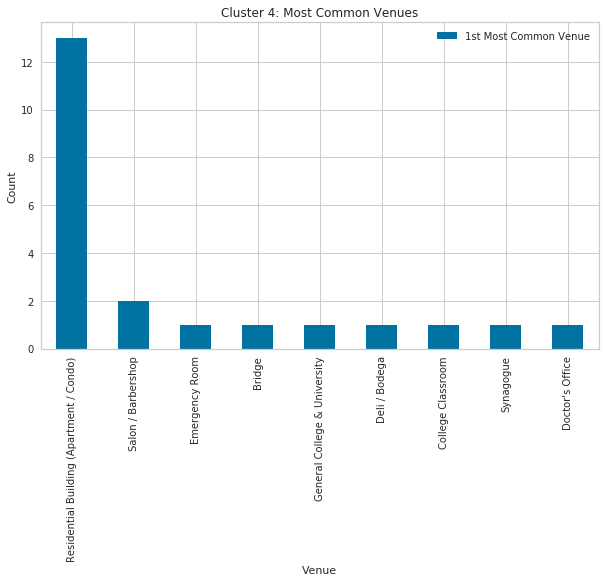

In [459]:
#Plot the Most Common Venues 
df4.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venue') #X-label
plt.ylabel('Count') #Y-label
plt.title('Cluster 4: Most Common Venues') #Plot Title

plt.show()

## Cluster 5: Professional & Service Venues

In [443]:
#5th Cluster(4)
clust5 = hood_merged.loc[hood_merged['Cluster Labels'] == 5, hood_merged.columns[[1] + list(range(5, hood_merged.shape[1]))]]
clust5

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7,Charleston,Building,Automotive Shop,Gym,Office,Gym / Fitness Center
32,Old Place,Building,Automotive Shop,Warehouse,Boat or Ferry,Hardware Store
35,Port Ivory,Boat or Ferry,Building,Food,Office,Automotive Shop
42,Rossville,Automotive Shop,Building,Other Great Outdoors,Pizza Place,Medical Center
77,Hunts Point,Automotive Shop,Building,Factory,School,Food
84,Port Morris,Building,Factory,Office,Storage Facility,General Entertainment
95,Eastchester,Automotive Shop,Bus Line,Caribbean Restaurant,Building,Auto Dealership
123,North Brother Island,Office,Building,Automotive Shop,Factory,Pool
124,South Brother Island,Building,Office,Factory,Storage Facility,Prison
125,Rikers Island,Building,Prison,Seafood Restaurant,Factory,Government Building


In [454]:
#Examine cluster for most frequent, most common venues
#Create a table for count of common venues
df5 = clust5['1st Most Common Venue'].value_counts()
df5 = pd.DataFrame(df5)

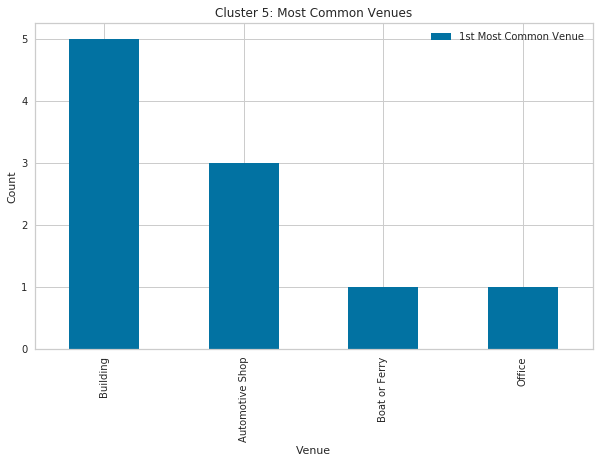

In [456]:
#Plot the Most Common Venues 
df5.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venue') #X-label
plt.ylabel('Count') #Y-label
plt.title('Cluster 5: Most Common Venues') #Plot Title

plt.show()

## Cluster 6: Service & Transport Venues

In [445]:
#5th Cluster(4)
clust6 = hood_merged.loc[hood_merged['Cluster Labels'] == 6, hood_merged.columns[[1] + list(range(5, hood_merged.shape[1]))]]
clust6

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Arlington,Automotive Shop,Bus Stop,Church,Building,Deli / Bodega
8,Clifton,Bus Stop,Hospital,Church,Moving Target,Building
12,Elm Park,Automotive Shop,Gas Station,Deli / Bodega,School,Salon / Barbershop
22,Hamilton Park,Bus Stop,Deli / Bodega,Building,Church,Housing Development
26,Mariners Harbor,Church,Bus Stop,Deli / Bodega,Salon / Barbershop,Automotive Shop
28,New Brighton,High School,Bus Stop,Church,Residential Building (Apartment / Condo),Building
36,Port Richmond,Deli / Bodega,Building,Salon / Barbershop,Automotive Shop,Mexican Restaurant
38,Randall Manor,High School,Art Gallery,Garden,Building,Historic Site
47,Tompkinsville,Deli / Bodega,Bus Stop,Pizza Place,Church,Salon / Barbershop
50,Travis,Automotive Shop,Salon / Barbershop,Hotel,Park,Church


In [453]:
#Create a table for count of common venues
df6 = clust6['1st Most Common Venue'].value_counts()
df6 = pd.DataFrame(df6)


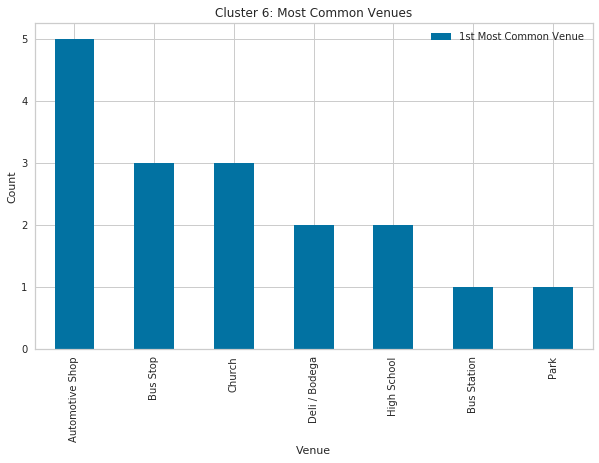

In [452]:
#Plot the Most Common Venues 
df6.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Venue') #X-label
plt.ylabel('Count') #Y-label
plt.title('Cluster 6: Most Common Venues') #Plot Title

plt.show()